In [130]:
import numpy as np
import pandas as pd
from Module import Lineaire, MSE
from tools import get_patches, pad_to_32
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Linear regression
Let's start by preparing the data. We will use Boston dataset.

In [7]:
columns = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO','B','LSTAT', 'MEDV'])
data = pd.read_csv("housing.data", sep=r'\s{1,}', engine="python", names=columns, dtype='float')

Let's visualise the dataset a little. Let's plot a subset of variables one-vs-one to find pair of variables that are quite correlated. Variables NOX and INDUS seems to be correlating (that makes reason), so let's use them to test linear regression.

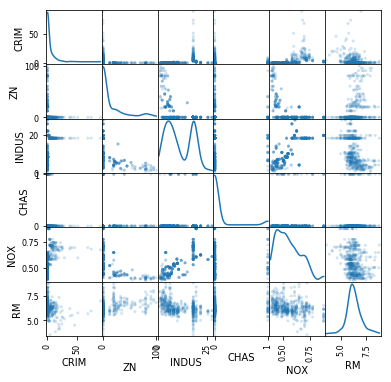

In [173]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[data.columns[:6]], alpha = 0.2, figsize = (6, 6), diagonal = 'kde');

In [132]:
variables = data[['NOX']].values
biaised_X = np.concatenate((np.ones(data.shape[0]).reshape(-1,1), variables), axis=1)
X_train, X_test, y_train, y_test = train_test_split(biaised_X, 
                                                    data['INDUS'].values, 
                                                    test_size=0.5, random_state=42)

X_train, y_train = pad_to_32(X_train, y_train)
X_test, y_test = pad_to_32(X_test, y_test)

In [19]:
torch.cuda.set_device(0)

In [134]:
dim_in = 2
dim_out = 1

epsilon = 0.01
model = Lineaire(dim_in, dim_out)
model.initialize_parameters()

def linear_regression(model, epsilon, X_train, y_train, X_test, y_test):
    loss = MSE()

    errors = []
    test_errors = []
    for epoch in range(1000):   
        for batch in get_patches(len(X_train)): # X_train a le méme taille que X_test
            model.grad_zero()
            n = len(batch)
            X = torch.from_numpy(X_train[batch].reshape(-1,n)).float()
            y = torch.from_numpy(y_train[batch].reshape(-1,n)).float()

            X_t = torch.from_numpy(X_test[batch].reshape(-1,n)).float()
            y_t = torch.from_numpy(y_test[batch].reshape(-1,n)).float()

            yhat = model.forward(X)
            err = loss.forward(y,yhat)

            yhat_test = model.forward(X_t)
            test_err = loss.forward(y_t,yhat_test)

            delta_Z = loss.backward(y,yhat)
            model.backward_update_gradient(X , delta_Z)
            model.update_parameters(epsilon)
        errors.append(err)
        test_errors.append(test_err)
    return model, errors, test_errors

model, errors, test_errors = linear_regression(model, epsilon, X_train, y_train, X_test, y_test)
print(model.W)

tensor([[6.2457],
        [6.9108]])


## Visual evaluation
So let's plot NIX ~ INDUS to see, if learned model is useful or not.

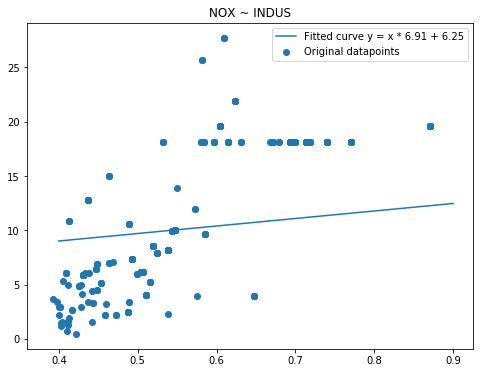

In [135]:
plt.figure(figsize=(8,6))
plt.title("NOX ~ INDUS")
plt.scatter(X_test[:,1], y_test, label="Original datapoints")
artificiel_x = np.linspace(0.4,0.9,100)
a = model.W.tolist()[1][0]
b = model.W.tolist()[0][0]
plt.plot(artificiel_x, artificiel_x * a + b, label="Fitted curve y = x * " +str(round(a,2))+" + " + str(round(b,2)))
plt.legend();

## 1.3 Quantitative evaluation
Model was visually giving something useful. Let's plot next the error in training and test.

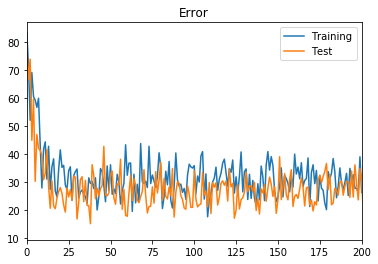

In [138]:
plt.figure()
plt.title("Error")
plt.plot(list(range(len(errors))), errors, label="Training")
plt.plot(list(range(len(test_errors))), test_errors, label="Test")
plt.xlim(0,200)
plt.legend();

The test error seems to be allways less than training error in this case. Let's test also other variables.

tensor([[0.2080],
        [0.2054],
        [0.1963]])


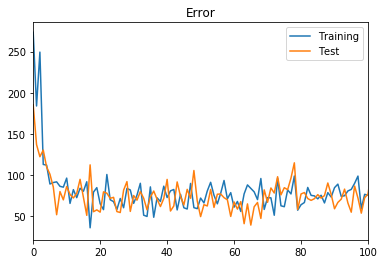

In [144]:
variables = data[['NOX', 'ZN']].values
biaised_X = np.concatenate((np.ones(data.shape[0]).reshape(-1,1), variables), axis=1)
X_train, X_test, y_train, y_test = train_test_split(biaised_X, 
                                                    data['INDUS'].values, 
                                                    test_size=0.5, random_state=42)
X_train, y_train = pad_to_32(X_train, y_train)
X_test, y_test = pad_to_32(X_test, y_test)

dim_in = 3
dim_out = 1

epsilon = 0.0001
model = Lineaire(dim_in, dim_out)
model.initialize_parameters()

model, errors, test_errors = linear_regression(model, epsilon, X_train, y_train, X_test, y_test)
print(model.W)

plt.figure()
plt.title("Error")
plt.plot(list(range(len(errors))), errors, label="Training")
plt.plot(list(range(len(test_errors))), test_errors, label="Test")
plt.xlim(0,100)
plt.legend();

This time test error is bigger that training error, which seems more logic.

## 1.4 Batch and Mini-Batch gradient descent

Previously I implemented mini-batch version of gradient descent. I will now implement also batch and compare convergence speed.

In [50]:
def linear_regression_batch(model, epsilon, X_train, y_train, X_test, y_test):
    loss = MSE()

    errors = []
    test_errors = []
    for epoch in range(1000):   
        model.grad_zero()
        X = torch.from_numpy(X_train.reshape(-1,X_train.shape[0])).float()
        y = torch.from_numpy(y_train.reshape(-1,X_train.shape[0])).float()

        X_t = torch.from_numpy(X_test.reshape(-1,X_test.shape[0])).float()
        y_t = torch.from_numpy(y_test.reshape(-1,X_test.shape[0])).float()

        yhat = model.forward(X)
        err = loss.forward(y,yhat)

        yhat_test = model.forward(X_t)
        test_err = loss.forward(y_t,yhat_test)

        delta_Z = loss.backward(y,yhat)
        model.backward_update_gradient(X , delta_Z)
        model.update_parameters(epsilon)
        errors.append(err)
        test_errors.append(test_err)
    return model, errors, test_errors

tensor([[0.1519],
        [0.0985],
        [0.3263],
        [0.2063]])
tensor([[0.1726],
        [0.1565],
        [0.1720],
        [0.1744]])


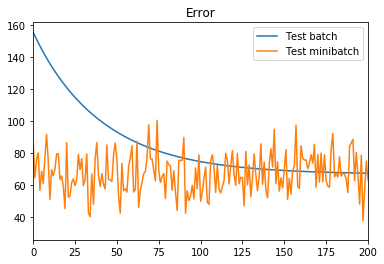

In [148]:
variables = data[['NOX', 'ZN', 'RM']].values
biaised_X = np.concatenate((np.ones(data.shape[0]).reshape(-1,1), variables), axis=1)
X_train, X_test, y_train, y_test = train_test_split(biaised_X, 
                                                    data['INDUS'].values, 
                                                    test_size=0.5, random_state=42)
X_train, y_train = pad_to_32(X_train, y_train)
X_test, y_test = pad_to_32(X_test, y_test)

dim_in = 4
dim_out = 1

epsilon = 0.0001
model = Lineaire(dim_in, dim_out)
model.initialize_parameters()


model, errors_batch, test_errors_batch = linear_regression_batch(model, epsilon, X_train, y_train, X_test, y_test)
print(model.W)

model, errors, test_errors = linear_regression(model, epsilon, X_train, y_train, X_test, y_test)
print(model.W)

plt.figure()
plt.title("Error")
#plt.plot(list(range(len(errors_batch))), errors_batch, label="Training batch")
plt.plot(list(range(len(test_errors_batch))), test_errors_batch, label="Test batch")
#plt.plot(list(range(len(errors))), errors, label="Training minibatch")
plt.plot(list(range(len(test_errors))), test_errors, label="Test minibatch")
plt.xlim(0,200)
plt.legend();

Nous pouvons constater que le descend de gradient batch converge plus lentement, mais vers un valeur stable. Minibatch par contre ne converge pas vraiement, il se varier en tour d'erreur obtenu par batch.